In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ants

# %matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_rows', 100)
    
root_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/'
data_path = '/home/lucas/projects/mmml-alzheimer-diagnosis/data/'

In [2]:
def split_cols(df):
    df['ORIENTATION'] = [x[0] for x in df['RUN_ID'].str.split('_')]
    df['SLICE'] = [int(x[1]) for x in df['RUN_ID'].str.split('_')]
    df['RUN'] = [int(x[2]) for x in df['RUN_ID'].str.split('_')]
    return df

def calculate_mean_performance(df):
    return df.groupby(["ORIENTATION","SLICE"]).mean().reset_index().sort_values("SLICE")


# Slices Example

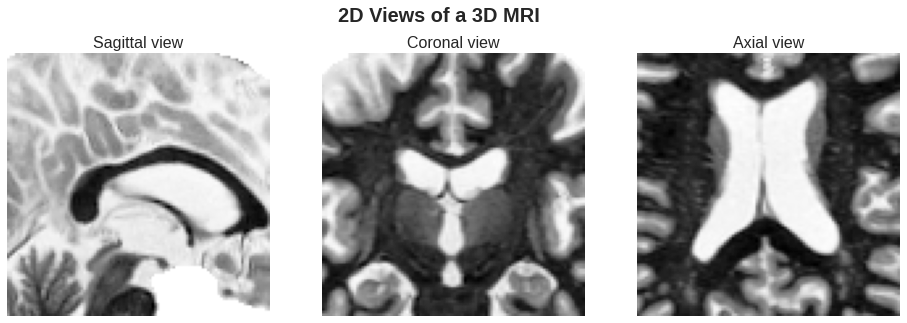

In [5]:
img_path = data_path+'mri/002_S_0295_MR_MT1__N3m_Br_20110623105302806_S110476_I241350_CN.nii.gz'
img_path = data_path+'mri/002_S_0413_MR_MPR____N3__Scaled_2_Br_20081124142730828_S22683_I128346_MCI.nii.gz'

fig, ax = plt.subplot_mosaic([
    ['sagittal', 'coronal','axial']
], figsize=(16, 10))

img = ants.image_read(img_path).numpy()

ax['sagittal'].imshow(np.rot90(img[50,:,:]))
ax['sagittal'].axis('off')
ax['sagittal'].set_title("Sagittal view",fontsize=16)

ax['coronal'].imshow(np.rot90(img[:,50,:]))
ax['coronal'].axis('off')
ax['coronal'].set_title("Coronal view",fontsize=16)

ax['axial'].imshow(np.rot90(img[:,:,50]))
ax['axial'].axis('off')
ax['axial'].set_title("Axial view",fontsize=16)

plt.suptitle("2D Views of a 3D MRI",x=0.5,y=0.75,fontsize=20,weight='heavy')
plt.show()

# MCI Slice Search AD x CN

First run around regions with best results shown in Nigri,2020

In [24]:
df_coronal = pd.read_csv(data_path+"SLICES_SEARCH_AD_CORONAL_VGG11.csv")
df_axial = pd.read_csv(data_path+"SLICES_SEARCH_AD_AXIAL_VGG11.csv")
df_sagittal = pd.read_csv(data_path+"SLICES_SEARCH_AD_SAGITTAL_VGG11.csv")

df_coronal = calculate_mean_performance(split_cols(df_coronal))
df_axial = calculate_mean_performance(split_cols(df_axial))
df_sagittal = calculate_mean_performance(split_cols(df_sagittal))

df_coronal.columns = df_coronal.columns.str.upper()
df_axial.columns = df_axial.columns.str.upper()
df_sagittal.columns = df_sagittal.columns.str.upper()

df_more_slices = pd.read_csv(data_path+'SLICES_SEARCH_AD_VGG11_MORE_COR_AXI_SAG_SLICES.csv')
df_more_slices.columns = df_more_slices.columns.str.upper()
df_more_slices = calculate_mean_performance(df_more_slices)

df_first_run = pd.concat([df_coronal,df_axial,df_sagittal,df_more_slices])[['ORIENTATION','SLICE','VALIDATION_AUC']].sort_values(['ORIENTATION','SLICE'])
df_first_run = df_first_run.groupby(['ORIENTATION','SLICE']).mean().reset_index()
df_first_run['MODEL'] = 'VGG11_BN'
print("top 5 of each orientation:")
df_first_run_top5 = df_first_run.sort_values(['ORIENTATION','VALIDATION_AUC'],ascending=False).groupby("ORIENTATION").head(5)
df_first_run_top5

top 5 of each orientation:


,ORIENTATION,SLICE,VALIDATION_AUC,MODEL
43,sagittal,26,0.867521,VGG11_BN
44,sagittal,27,0.852633,VGG11_BN
45,sagittal,28,0.841800,VGG11_BN
52,sagittal,74,0.836148,VGG11_BN
40,sagittal,23,0.835539,VGG11_BN
35,coronal,56,0.829221,VGG11_BN
22,coronal,43,0.826372,VGG11_BN
33,coronal,54,0.813069,VGG11_BN
23,coronal,44,0.812448,VGG11_BN
32,coronal,53,0.808611,VGG11_BN


Second run with best slices of the first run

In [25]:
df_second_run = pd.read_csv(data_path+'SLICES_SEARCH_AD_VGG13_BN_MORE_COR_AXI_SAG_SLICES.csv')
df_second_run.columns = df_second_run.columns.str.upper()
df_second_run = calculate_mean_performance(df_second_run)[['ORIENTATION','SLICE','VALIDATION_AUC']].sort_values(['ORIENTATION','SLICE'])
df_second_run

,ORIENTATION,SLICE,VALIDATION_AUC
0,axial,20,0.779593
1,axial,21,0.799237
2,axial,22,0.811874
3,axial,23,0.831288
4,axial,28,0.818882
5,axial,29,0.811805
6,coronal,43,0.848291
7,coronal,44,0.822719
8,coronal,45,0.811254
9,coronal,55,0.804912


## Visualizing slices search

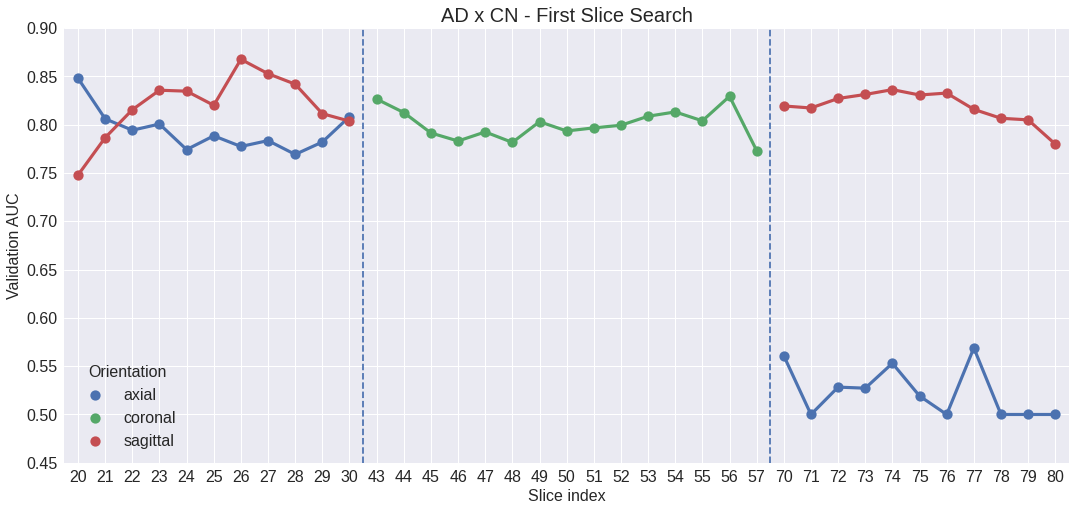

In [33]:
large_figure = (18,8)
plt.figure(figsize = large_figure)
sns.pointplot(data=df_first_run,x='SLICE',y='VALIDATION_AUC',hue='ORIENTATION',dashes=False,markers='o')
plt.legend(title='Orientation',fontsize=16,title_fontsize=16,loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Slice index',fontdict={'size':16})
plt.ylabel('Validation AUC',fontdict={'size':16})
plt.ylim(0.45,0.9)
plt.axvline(10.5, 0,1,linestyle='--')
plt.axvline(25.5, 0,1,linestyle='--')
plt.grid(True)
plt.title("AD x CN - First Slice Search",fontdict={'size':20})
plt.show()

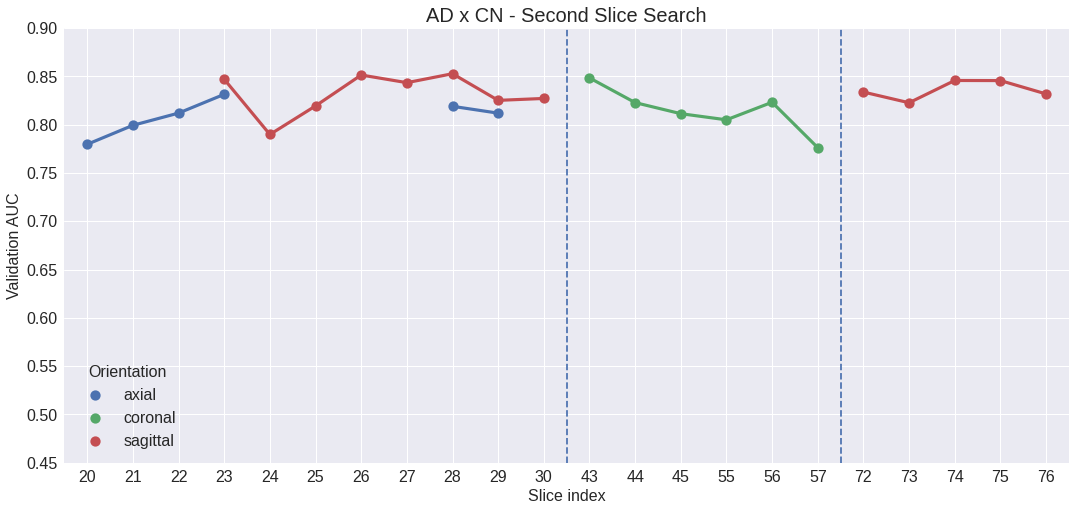

In [32]:
large_figure = (18,8)
plt.figure(figsize = large_figure)
sns.pointplot(data=df_second_run,x='SLICE',y='VALIDATION_AUC',hue='ORIENTATION',dashes=False,markers='o')
plt.legend(title='Orientation',fontsize=16,title_fontsize=16,loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Slice index',fontdict={'size':16})
plt.ylabel('Validation AUC',fontdict={'size':16})
plt.ylim(0.45,0.9)
plt.axvline(10.5, 0,1,linestyle='--')
plt.axvline(16.5, 0,1,linestyle='--')
plt.grid(True)
plt.title("AD x CN - Second Slice Search",fontdict={'size':20})
plt.show()

Slices chosen:

- Coronal = 43
- Axial = 23
- Sagittal = 26 (almost a tie between 26-28. 26 chosen due to highest performance in previous run)

# MCI Slice Search MCI x CN

In [35]:
df_coronal = pd.read_excel(data_path+"SLICES_SEARCH_MCI_FOCAL_LOSS_VGG11_BN_CORONAL.xlsx")
df_axial = pd.read_excel(data_path+"SLICES_SEARCH_MCI_FOCAL_LOSS_VGG11_BN_AXIAL.xlsx")
df_sagittal = pd.read_excel(data_path+"SLICES_SEARCH_MCI_FOCAL_LOSS_VGG11_BN_SAGITTAL.xlsx")

df_coronal.columns = df_coronal.columns.str.upper()
df_axial.columns = df_axial.columns.str.upper()
df_sagittal.columns = df_sagittal.columns.str.upper()

df_run = pd.concat([df_coronal,df_axial,df_sagittal])[['ORIENTATION','SLICE','VALIDATION_AUC']].sort_values(['ORIENTATION','SLICE'])
df_run = df_run.append({"ORIENTATION":'axial','SLICE':76,'VALIDATION_AUC':0.643},ignore_index=True) #interpolating missing point
df_run['SLICE'] = df_run['SLICE'].astype(int)

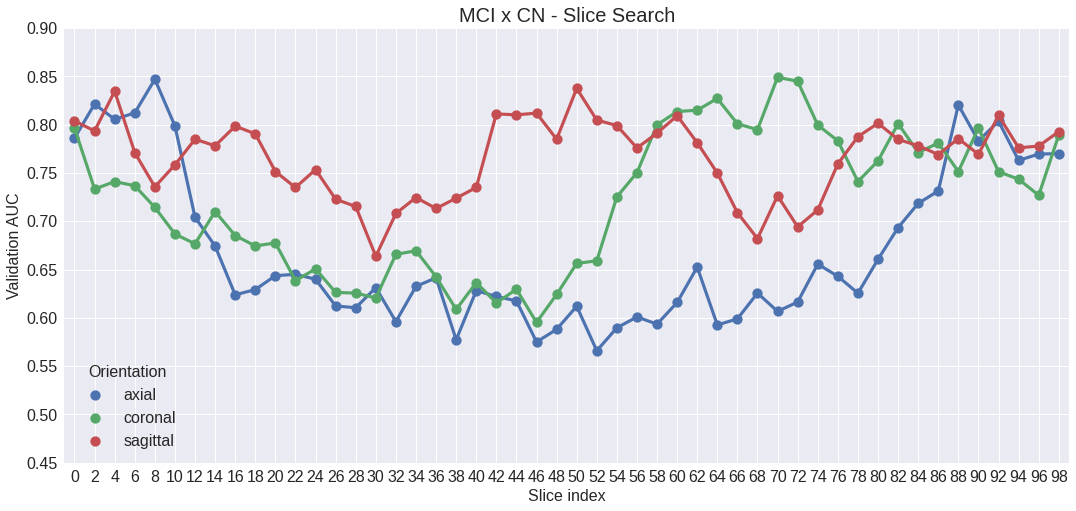

In [40]:
large_figure = (18,8)
plt.figure(figsize = large_figure)
sns.pointplot(data=df_run,x='SLICE',y='VALIDATION_AUC',hue='ORIENTATION',dashes=False,markers='o')
plt.legend(title='Orientation',fontsize=16,title_fontsize=16,loc='lower left')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Slice index',fontdict={'size':16})
plt.ylabel('Validation AUC',fontdict={'size':16})
plt.ylim(0.45,0.9)
plt.grid(True)
plt.title("MCI x CN - Slice Search",fontdict={'size':20})
plt.show()

Slices chosen:

- Coronal = 70
- Axial = 8
- Sagittal = 50